In [157]:
import os, re
import pandas as pd
import datetime
import nltk
import numpy as np
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
from gensim import corpora, models, similarities 
from gensim.parsing.preprocessing import remove_stopwords
import spacy
import itertools
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
matplotlib.use('agg')
import itertools
import pickle
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()

In [158]:
stops = nltk.corpus.stopwords.words('english')+['can','will','also','health','healthcare','datum','data'
                                               'technology','technolog','care']

In [ ]:
#stops = get_stop_words('en')
#stops = stops +['"s',"'s",'s','can','will','also']

In [ ]:
#pt = nltk.stem.PorterStemmer()

In [159]:
nlp = spacy.load('en')#, disable=['parser', 'ner'])

In [ ]:
#spacy.load('en')

In [ ]:
rootDir = '../LDA/'
d = {}
wh = []
for dirName, subdirList, fileList in os.walk(rootDir) :
    print('Found directory: %s' % dirName)
    #print(dirName)
    #print(len(fileList))
    c = 0

    if dirName !='../LDA/.ipynb_checkpoints' and dirName != '../LDA/'\
    and dirName != '../LDA/fintech_re':
        print(dirName)
        news_name = dirName.replace('../LDA/','')
        d[news_name] = {}
        c = 0
        for fname in fileList: 
            if fname.endswith(".txt"):  
                filepath = os.path.join(dirName, fname)
                with open(filepath, 'r', -1) as input_file:
                    data = input_file.read()
                    #print(data)
                    if data != '':
                        try:                                
                            if news_name == 'healthitarticle':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != ''and 'tagged' not in item.lower()]
                                body = re.sub(r'\w+\s\d{1,2}\,\s\d{4}\s\-\s+','', tls[3])
                                tls[3] = re.sub('LAS VEGAS – ','', body)
                                whole_text = " ".join(tls[3:]) 
                            if news_name == 'aitho':
                                c+=1
                                if fname == 'aitho_article_1792.txt':
                                    date = re.findall(r'\d{1,2}\s\w+\s\d{4}', data)[1]
                                else:
                                    date = re.search(r'\d{1,2}\s\w+\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%d %b %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'fintech':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'reinsu':
                                c +=1
                                date = re.search(r'\d{1,2}\w+\s\w+\s\d{4}', data).group(0)
                                date = re.sub(r'(?<=[0-9])(?:st|nd|rd|th)', '',date)
                                date_obj = datetime.strptime(date, '%d %B %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 

                        except Exception as e:
                            print(news_name, fname)
                            print(e)
            d[news_name][c] = {'date':date_obj, 'text':whole_text, 
                                'whole':tls, 'filepath':filepath}

In [ ]:
#[item for item in data.split('\n') if item != '' and 'tagged' not in item.lower()]
#[item for item in tp if item != '' and 'tagged' not in item.lower()]

In [ ]:
#tp = d['healthitarticle'][1]['whole']
#tp

In [ ]:
for i, v in d.items():
    print(i, len(v))

In [ ]:
temp = {}
for news_name, values1 in d.items():
    for number, values2 in values1.items():
        temp.setdefault('newsname', []).append(news_name)
        temp.setdefault('number', []).append(number)
        for key, value in values2.items():
            #for key, value in date.items():
            temp.setdefault(key, []).append(value)

In [ ]:
df = pd.DataFrame(temp)

In [ ]:
df[['date','newsname','text','whole']].shape[0]

In [ ]:
df_clean = df.drop_duplicates(subset=['date','newsname','text'])

In [ ]:
df_drop = df[df.duplicated(subset=['date','newsname','text'])]

In [ ]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [ ]:
df_clean['year'] = df_clean['date'].dt.year

In [ ]:
df_clean.groupby('newsname').count()

In [ ]:
#df_clean.to_csv('insuretech_newspaper_all_fine.csv', index = False)

In [160]:
df_clean = pd.read_csv('insuretech_newspaper_all_fine.csv')

In [161]:
text_ls = list(df_clean['text'])

In [162]:
from gensim.parsing.preprocessing import stem_text, strip_punctuation, strip_punctuation2

In [163]:
total_text = text_ls

In [164]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [165]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
        text = re.sub(r'\((?!k\))(?!b\))(.*?)\)',' ', text, flags= re.IGNORECASE)
        try:
            tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent) if word.lower() not in stops]              
            filtered_tokens = []
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    token = re.sub(r'[^\w\s]', '', token)
                    filtered_tokens.append(token.lower())
            stems = [stemmer.stem(t) for t in filtered_tokens if t not in stops]
            stems = [word for word in stems if word not in stops]
            tokenized_text.append(stems)
        except Exception as e:
            print(e)
            print(k)
    return tokenized_text

In [166]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stops])
    return texts_out

In [174]:
# Tokenized, remove stop words, stemming the whole texts
%time data_words = tokenized_gensim(total_text)

CPU times: user 2min 20s, sys: 993 ms, total: 2min 21s
Wall time: 2min 23s


In [175]:
# Build the bigram and trigram models
%time bigram = gensim.models.Phrases(data_words,\
                                     min_count=5, threshold=10) 
# higher threshold fewer phrases.
%time trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod = gensim.models.phrases.Phraser(bigram)
%time trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 7.87 s, sys: 422 ms, total: 8.29 s
Wall time: 8.51 s
CPU times: user 21.4 s, sys: 353 ms, total: 21.8 s
Wall time: 21.9 s
CPU times: user 19.2 s, sys: 34.3 ms, total: 19.2 s
Wall time: 19.3 s
CPU times: user 26.8 s, sys: 61.9 ms, total: 26.9 s
Wall time: 27.1 s


In [176]:
# Remove Stop Words
%time data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
%time data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

CPU times: user 13.3 s, sys: 377 ms, total: 13.7 s
Wall time: 13.8 s
CPU times: user 10.7 s, sys: 3.07 s, total: 13.8 s
Wall time: 14.4 s


In [177]:
# Form Trigrams
%time data_words_trigrams = make_trigrams(data_words_nostops)

CPU times: user 19.2 s, sys: 362 ms, total: 19.6 s
Wall time: 19.7 s


In [ ]:
#len(data_lemmatized_tri[100])

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized = lemmatization(data_words_bigrams,\
                                      allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])

In [178]:
# Do lemmatization keeping only noun, adj, vb, adv with tri
%time data_lemmatized_tri = lemmatization(data_words_trigrams,\
                                      allowed_postags=['NOUN'])

CPU times: user 12min 16s, sys: 1min 58s, total: 14min 14s
Wall time: 9min 15s


In [179]:
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(data_lemmatized_tri)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=5, no_above=0.6)%%!₩

CPU times: user 1.6 s, sys: 14.8 ms, total: 1.62 s
Wall time: 1.65 s
CPU times: user 178 ms, sys: 9.8 ms, total: 188 ms
Wall time: 189 ms


In [180]:
dicls = list(dictionary.values())

In [191]:
#dicls

In [ ]:
for i, tx in enumerate(data_lemmatized_tri):
    if 'databig' in tx:
        print(i)

In [ ]:
total_text[3836]

In [ ]:
for w in dicls:
    if 'big' in w:
        print(w)

In [ ]:
# for k, v in dictionary.token2id.items():
#     print(k, v)

In [181]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in data_lemmatized_tri]

CPU times: user 1.23 s, sys: 110 ms, total: 1.34 s
Wall time: 1.38 s


In [ ]:
#corpus

In [182]:
####### LDA model
%time ldamodel = models.LdaModel(corpus, num_topics=10, \
                                   id2word=dictionary, update_every=5,\
                                 chunksize=3000, passes=20)

CPU times: user 3min 22s, sys: 2.31 s, total: 3min 25s
Wall time: 3min 24s


In [183]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=10, num_topics=10)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

allls = []
allls1 = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)
    allls1.append([wordls])

['busi', 'compani', 'innov', 'market', 'bank', 'digit', 'fintech', 'partner', 'custom', 'product']
['blockchain', 'platform', 'compani', 'market', 'bank', 'payment', 'transact', 'cryptocurr', 'investor', 'user']
['custom', 'manag', 'busi', 'platform', 'process', 'compani', 'system', 'product', 'market', 'autom']
['hospit', 'system', 'patient', 'organ', 'vendor', 'tool', 'work', 'manag', 'realli', 'inform']
['platform', 'system', 'user', 'design', 'network', 'mobil', 'power', 'drone', 'compani', 'test']
['research', 'precis_medicin', 'cancer', 'patient', 'clinic', 'project', 'genom', 'collabor', 'big_data', 'treatment']
['program', 'patient', 'hospit', 'system', 'improv', 'communiti', 'state', 'report', 'qualiti', 'access']
['patient', 'percent', 'research', 'clinic', 'system', 'manag', 'tool', 'studi', 'time', 'popul']
['organ', 'system', 'patient', 'ehr', 'inform', 'provid', 'interoper', 'physician', 'tool', 'manag']
['market', 'custom', 'compani', 'consum', 'brand', 'product', 'platf

In [186]:
pd.DataFrame(allls)

,0,1,2,3,4,5,6,7,8,9
0,busi,compani,innov,market,bank,digit,fintech,partner,custom,product
1,blockchain,platform,compani,market,bank,payment,transact,cryptocurr,investor,user
2,custom,manag,busi,platform,process,compani,system,product,market,autom
3,hospit,system,patient,organ,vendor,tool,work,manag,realli,inform
4,platform,system,user,design,network,mobil,power,drone,compani,test
5,research,precis_medicin,cancer,patient,clinic,project,genom,collabor,big_data,treatment
6,program,patient,hospit,system,improv,communiti,state,report,qualiti,access
7,patient,percent,research,clinic,system,manag,tool,studi,time,popul
8,organ,system,patient,ehr,inform,provid,interoper,physician,tool,manag
9,market,custom,compani,consum,brand,product,platform,content,person,sale


In [187]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(dataprepared)

In [ ]:
pyLDAvis.save_html(dataprepared, 'lda_tri.html')

In [192]:
## SAVE 
dictionary.save('dictionary_tri.dict')
corpora.MmCorpus.serialize('corpus_tri.mm', corpus)

In [193]:
## SAVE TEXTS
with open("data_lemmetized_tri.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)

In [194]:
### SAVE MODEL
ldamodel.save('ldamodel_tri.model')

In [ ]:
## LOAD
dictionary = gensim.corpora.Dictionary.load('dictionary_tri.dict')
corpus = gensim.corpora.MmCorpus('corpus_tri.mm')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel_tri.model')
with open("data_lemmetized_tri.txt",'rb')as f:
    data_lemmatized = pickle.load(f)
    f.close()

In [ ]:
dictionary.num_pos

In [ ]:
dictionary.num_nnz

# Finding optimal number of topics

In [ ]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, 5))
    parameter_list[0] = start
    grid ={}
    cv_dic = {}
    for num_topics in parameter_list:
        print(num_topics)

        model = models.LdaModel(corpus, num_topics=num_topics,\
                                id2word=dictionary, \
                                      update_every=5, chunksize=500,  passes=20)
        model_list.append(model)
        perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        cv_dic[num_topics]=[]
        cv_dic[num_topics].append(coherencemodel.get_coherence())

    return model_list, cv_dic, grid

In [ ]:
%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=dictionary,\
                                                                           corpus=corpus,\
                                                       texts=data_lemmatized, start=2, limit=50, step=5)

In [ ]:
coherence_values_rev

In [ ]:
grid_rev

In [ ]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(coherence_values_rev)

axcv = plt.figure(figsize=(6,4)).add_subplot(111)
plt.plot(dfcv.iloc[0].transpose())

In [ ]:
# perplexity
dfp = pd.DataFrame(grid_rev)
plt.plot(dfp.iloc[0].transpose())

# simple_process


In [ ]:
# Build the bigram and trigram models
%time bigram2 = gensim.models.Phrases(tokenized_text,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Remove Stop Words
%time data_words_nostops2 = remove_stopwords(tokenized_text)
# Form Bigrams
%time data_words_bigrams2 = make_bigrams(bigram_mod2, data_words_nostops2)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized2 = lemmatization(data_words_bigrams2,\
                                      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#create a Gensim dictionary from the texts
%time dictionary2= corpora.Dictionary(data_lemmatized2)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary2.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
#convert the dictionary to a bag of words corpus for reference
%time corpus2 = [dictionary2.doc2bow(text2) for text2 in data_lemmatized2]

In [ ]:
####### LDA model
%time ldamodel2 = models.LdaModel(corpus2, num_topics=20, \
                                   id2word=dictionary2, update_every=5,\
                                 chunksize=500, passes=20)

In [ ]:
# Get the topic related words 
topics_matrix2 = ldamodel2.show_topics(formatted=False, num_words=15, num_topics=15)
topics_matrix2 = np.array(topics_matrix2, dtype=object)
topic_words2 = topics_matrix2[:,1]

allls2 = []
allls12 = []
for k2 in range(len(topic_words2)):
    wordls2 = []
    for i2, v2 in topic_words2[k2]:
        wordls2.append(i2)
    print(wordls2)
    allls.append(wordls2)
    allls1.append([wordls2])

In [ ]:
dataprepared2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2)
pyLDAvis.display(dataprepared2)

# calculate topic distribution

In [195]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [196]:
do = _extract_data(ldamodel, corpus, dictionary)

In [197]:
dtt = pd.DataFrame(do['doc_topic_dists']).reset_index()

In [198]:
dtt['year'] = df_clean['year']

In [199]:
dttm = pd.melt(dtt, id_vars=['index','year'], value_vars=[0,1,2,3,4,5,6,7,8,9])

In [200]:
dttm.rename(columns={'index':'doc_index','variable':'topic_no','value':'topic_weight'}, inplace = True)

In [201]:
dtm1 = dttm.pivot(index='doc_index', columns='topic_no', values='topic_weight').fillna(0)

In [202]:
dtm2 = dtm1.div(dtm1.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm2 = dtm2.stack().reset_index()
dt_norm2.columns = ['doc_index', 'topic_id', 'norm_topic_weight']

In [ ]:
len(text_ls)

In [203]:
dt_norm21 = dt_norm2.merge(dttm[['year','doc_index']] ,on = 'doc_index').drop_duplicates()

In [ ]:
#text_ls[674]

In [ ]:
#wh[235]

In [204]:
max_df = dt_norm21[dt_norm21.groupby(['doc_index'])['norm_topic_weight'].transform(max) == dt_norm21['norm_topic_weight']]

In [205]:
topic1 = max_df[max_df['topic_id'] == 0]
topic1.sort_values('norm_topic_weight', ascending=False)

,doc_index,topic_id,norm_topic_weight,year
478000,4780,0,0.998217,2018
255200,2552,0,0.997527,2018
236900,2369,0,0.997264,2018
490600,4906,0,0.997115,2018
287500,2875,0,0.996928,2018
329400,3294,0,0.996715,2018
295200,2952,0,0.996703,2017
323800,3238,0,0.996666,2017
313100,3131,0,0.996577,2017
286800,2868,0,0.996470,2017


In [206]:
max_counts = max_df[['doc_index', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_index' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [207]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_index']].groupby('year').agg({'doc_index' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [ ]:
total_docs

In [208]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

In [209]:
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']


In [212]:
cm = plt.cm.get_cmap('tab10')
cm_skip = [cm.colors[i] for i in range(len(cm.colors))]

In [213]:
xi = [
 2013,
 2014,
 2015,
 2016,
 2017]

In [214]:
# ### TOPIC PREVALENCE
# #for key, data in max_counts.groupby('topic_id'):
# for i in range(0,10):
#     data = dy.merge(max_counts[max_counts['topic_id'] == i],
#                     on = 'year', how = 'left').fillna(0)
#     ax3 = data.plot(x='year', y='prevalence', 
#               label=key, color = cm_skip[i], legend = False, figsize = (11,2))
#     ax3.set_ylim(0,0.5)
#     #ax3.set_xlim(-0.5,0.5)
#     ax3.set_facecolor("white")
#     ax3.spines['left'].set_visible(False)
#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
#     #ax2.set_ylim(0,250)
#     ax3.set_xlabel('')
#     plt.xticks(data['year'])
#     name = "Topic #" + str(i+1) +'pv_by_year21'
#     plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#     #plt.savefig('Figures/'+str(name)+'.png',dpi=800,facecolor='w',bbox_inches = 'tight')    
#     #plt.close()

In [216]:
#max_counts

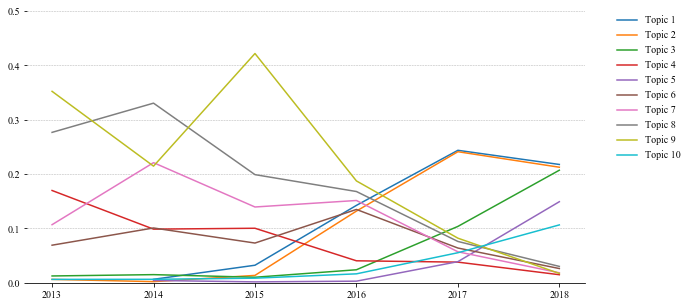

In [223]:
fig, ax4 =plt.subplots()
mylabels = ['Topic 1','Topic 2',
           'Topic 3','Topic 4',
           'Topic 5','Topic 6',
           'Topic 7','Topic 8',
           'Topic 9','Topic 10']
for key, data in max_counts.groupby('topic_id'):
    #data.plot(x='year', y='prevalence', ax=ax, label=key)
    #data = nn1
    ax4 = data.plot(x='year', y='prevalence', ax = ax4,
              label=key, color = cm_skip[key], figsize = (10,5))
    ax4.set_ylim(0,0.5)
    #ax3.set_xlim(-0.5,0.5)
    ax4.set_facecolor("white")
    ax4.spines['left'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    #ax2.set_ylim(0,250)
    ax4.set_xlabel('')
    plt.xticks(data['year'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               labels=mylabels,frameon=False)
    #name = str(i+1) +'pv_by_p'
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    #plt.savefig('Figures/'+'90-97.png', dpi=800,facecolor='w',bbox_inches='tight')    
    #plt.close()

# Graph

In [ ]:
NUMDOCS = 60 # number of subreddits OR number of BBC documents per category
NUMTOPICS = 10
def toVector(l):
    ''' inserts 0s for unrepresented topics in a document
        input: return value from ldamodel.get_document_topics(corpus[i])
        output: document topics with 0s for unrepresented topics'''
    ret = []
    t = 0
    for i in range(NUMTOPICS):
        if t == len(l):
            ret += [0]
        elif l[t][0] == i + 1:
            ret += [l[t][1]]
            t = t + 1
        else:
            ret += [0]
    return ret

In [ ]:
#text_ls#

In [ ]:
EPS = 0.001
numDocs = len(text_ls)
# note: this can take a long time on large corpora
similarity = [[0 for x in range(numDocs)] for y in range(numDocs)]

for i in range(numDocs):
    itops = toVector(ldamodel.get_document_topics(corpus[i]))
    for j in range(numDocs)[i:]:
        jtops = toVector(ldamodel.get_document_topics(corpus[j]))
        sim = 1.0 - gensim.matutils.hellinger(itops, jtops)
        sim = min(sim + EPS, 1.0)
        
        similarity[i][j] = sim


In [ ]:
type(similarity)

In [ ]:
import pickle

In [ ]:
with open('similarity','wb') as f:
    pickle.dump(similarity,f)

In [ ]:
d = pickle.load(open('similarity', 'rb'))

In [ ]:
len(d)

In [ ]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=800,
    height=600,
    stopwords= stops#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(ldamodel.num_topics):
    name = "Topic #" + str(t+1)
    plt.figure().subplots_adjust(bottom=0, top=1, left=0, right=1)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    #plt.title("Topic #" + str(t))
    
    plt.savefig(str(name)+'.png', dpi=300,facecolor='w',bbox_inches="tight", pad_inches = 0)
    plt.close()
    #plt.close()
    #plt.show()